## NLP From Scratch：使用char-RNN对姓氏进行分类

具体来说，我们将训练起源于18种语言的数千种姓氏，并根据拼写来预测姓氏来自哪种语言，从[此处](https://download.pytorch.org/tutorial/data.zip)下载数据

In [9]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
# 作用就是把Unicode转换为ASCII
def unicodeToAscii(s):
    return ''.join(
    # NFD表示字符应该分解为多个组合字符表示
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Greek.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/Polish.txt', 'data/names/English.txt', 'data/names/Russian.txt', 'data/names/Czech.txt', 'data/names/Spanish.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Vietnamese.txt', 'data/names/Dutch.txt', 'data/names/Irish.txt', 'data/names/Portuguese.txt', 'data/names/French.txt', 'data/names/Italian.txt']
Slusarski


### 将姓氏转化为张量

我们已经处理好了所有的姓氏，现在我们需要将它们转换为张量以使用它们。

为了表示单个字母，我们使用大小为<1 x n letters>的“独热向量”。一个独热向量就是在字母索引处填充1，其他都填充为0，例，"b" = <0 1 0 0 0 ...>

为了表达一个单词，我们将一堆字母合并成2D矩阵，其中矩阵的大小为<line_length x 1 x n_letters>

In [19]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### 创建网络

这个RNN模块只有2个线性层，它们在输入和隐藏状态下运行，输出之后是LogSoftmax层。
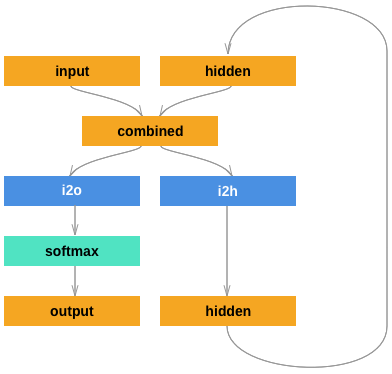

In [20]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

### 网络训练

因为RNN的最后一层是nn.LogSoftmax,所以我们选择损失函数nn.NLLLoss比较合适。

In [37]:
criterion = nn.NLLLoss()
learning_rate = 0.005 
# If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
    # 下面一行代码的作用效果为 p.data = p.data -learning_rate*p.grad.data，更新权重
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [38]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [40]:
import time
import math

n_iters = 100000
print_every = 10000



# Keep track of losses for plotting
current_loss = 0

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Add current loss avg to list of losses
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f' % (iter, iter / n_iters * 100, timeSince(start), current_loss / plot_every))
        current_loss = 0

10000 10% (0m 35s) 21.9794
20000 20% (1m 2s) 18.7553
30000 30% (1m 35s) 16.8407
40000 40% (2m 16s) 15.7836
50000 50% (2m 55s) 14.6169
60000 60% (3m 31s) 14.3172
70000 70% (4m 8s) 13.6765
80000 80% (4m 40s) 13.2454
90000 90% (5m 12s) 13.4152
100000 100% (5m 45s) 12.8359
